In [98]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

import utils
import exploration as exp
import pipeline as pipe

pd.set_option('display.max_rows', 1000)

In [2]:
data_dir = Path("../data/")
bizraw = pd.read_csv(data_dir/"Business_Licenses.csv")

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (9,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
bizraw.sort_values('LEGAL NAME').head()

,ID,LICENSE ID,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,LICENSE TERM START DATE,LICENSE TERM EXPIRATION DATE,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,LICENSE STATUS CHANGE DATE,SSA,LATITUDE,LONGITUDE,LOCATION
746469,1933435-20090227,1933435,337625,1,"""1758 W. GRAND AVENUE, INC.""",COCODRILOS GRILL,1758 W GRAND AVE 1ST,CHICAGO,IL,60622,...,02/27/2009,11/15/2010,02/27/2009,02/27/2009,AAI,NaN,NaN,41.891014,-87.671985,"(41.891013896751915, -87.67198480289699)"
811795,1933436-20090227,1933436,337625,1,"""1758 W. GRAND AVENUE, INC.""",COCODRILOS GRILL,1758 W GRAND AVE 1ST,CHICAGO,IL,60622,...,02/27/2009,11/15/2010,02/27/2009,02/27/2009,AAI,NaN,NaN,41.891014,-87.671985,"(41.891013896751915, -87.67198480289699)"
524368,1953650-20140216,2301373,279633,1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,CHICAGO,IL,60707,...,02/16/2014,02/15/2016,02/13/2014,02/18/2014,AAI,NaN,NaN,41.909062,-87.800245,"(41.90906215302536, -87.80024470792762)"
524358,1953650-20100216,2011565,279633,1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,CHICAGO,IL,60707,...,02/16/2010,02/15/2012,03/15/2010,03/16/2010,AAI,NaN,NaN,41.909062,-87.800245,"(41.90906215302536, -87.80024470792762)"
524362,1739434-20180216,2571799,279633,1,"""6978 W. NORTH, INC.""",6978 SOUL FOOD,6978 W NORTH AVE 1,CHICAGO,IL,60707,...,02/16/2018,02/15/2020,02/08/2018,02/09/2018,AAI,NaN,NaN,41.909062,-87.800245,"(41.90906215302536, -87.80024470792762)"


In [4]:
biz = bizraw.rename(columns = {'LICENSE TERM START DATE':'l_start', 'LICENSE TERM EXPIRATION DATE':'l_exp',
                             'LICENSE STATUS CHANGE DATE':'status_change'})
biz.l_start = pd.to_datetime(biz.l_start)
biz.l_exp = pd.to_datetime(biz.l_exp)
# biz['DATE ISSUED'] = pd.to_datetime(biz['DATE_ISSUED'])

KeyError: 'DATE_ISSUED'

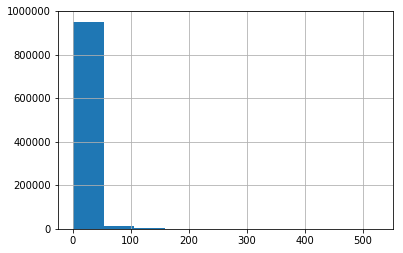

In [6]:
biz['SITE NUMBER'].hist()

In [7]:
biz.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968745 entries, 0 to 968744
Data columns (total 34 columns):
ID                                   968745 non-null object
LICENSE ID                           968745 non-null int64
ACCOUNT NUMBER                       968745 non-null int64
SITE NUMBER                          968745 non-null int64
LEGAL NAME                           968741 non-null object
DOING BUSINESS AS NAME               968685 non-null object
ADDRESS                              968745 non-null object
CITY                                 968740 non-null object
STATE                                968733 non-null object
ZIP CODE                             968332 non-null object
WARD                                 897358 non-null float64
PRECINCT                             867531 non-null float64
WARD PRECINCT                        897531 non-null object
POLICE DISTRICT                      872897 non-null float64
LICENSE CODE                         968745 non-n

In [8]:
biz.l_start.max()

Timestamp('2020-07-16 00:00:00')

LICENSE STATUS: 
* ‘AAI’ means the license was issued. 
* ‘AAC’ means the license was cancelled during its term. 
* ‘REV’ means the license was revoked. 
* 'REA' means the license revocation has been appealed.

APPLICATION TYPE: 
* ‘ISSUE’ is the record associated with the initial license application. 
* ‘RENEW’ is a subsequent renewal record. All renewal records are created with a term start date and term expiration date. 
* ‘C_LOC’ is a change of location record. It means the business moved. 
* ‘C_CAPA’ is a change of capacity record. Only a few license types may file this type of application. 
* ‘C_EXPA’ only applies to businesses that have liquor licenses. It means the business location expanded. 
* 'C_SBA' is a change of business activity record. It means that a new business activity was added or an existing business activity was marked as expired.

What do we think about cancellations for applications to expand or to change locations or business activities? Does this mean the whole business failed or does it mean they canceled their plans? Maybe this has the same result for a neighborhood.

In [9]:
recent = biz.loc[biz.l_start >= pd.to_datetime('2010-01-01')]
recent.groupby(['APPLICATION TYPE', 'LICENSE STATUS']).count()

ID  LICENSE ID  ACCOUNT NUMBER  \
APPLICATION TYPE LICENSE STATUS                                       
C_CAPA           AAC                 13          13              13   
                 AAI                 80          80              80   
C_EXPA           AAC                 31          31              31   
                 AAI                515         515             515   
                 REV                  2           2               2   
C_LOC            AAC                376         376             376   
                 AAI               4327        4327            4327   
                 REV                  5           5               5   
C_SBA            AAC                  7           7               7   
                 AAI                403         403             403   
ISSUE            AAC              11628       11628           11628   
                 AAI              95776       95776           95776   
                 INQ                  1           1               1   
                 REV                215         215             215   
RENEW            AAC              26016       26016           26016   
                 AAI             225403      225403          225403   
                 INQ                  1           1               1   
                 REA                 11          11              11   
                 REV                608         608             608   

                                 SITE NUMBER  LEGAL NAME  \
APPLICATION TYPE LICENSE STATUS                            
C_CAPA           AAC                      13          13   
                 AAI                      80          80   
C_EXPA           AAC                      31          31   
                 AAI                     515         515   
                 REV                       2           2   
C_LOC            AAC                     376         376   
                 AAI                    4327        4327   
                 REV                       5           5   
C_SBA            AAC                       7           7   
                 AAI                     403         403   
ISSUE            AAC                   11628       11628   
                 AAI                   95776       95775   
                 INQ                       1           1   
                 REV                     215         215   
RENEW            AAC                   26016       26016   
                 AAI                  225403      225400   
                 INQ                       1           1   
                 REA                      11          11   
                 REV                     608         608   

                                 DOING BUSINESS AS NAME  ADDRESS    CITY  \
APPLICATION TYPE LICENSE STATUS                                            
C_CAPA           AAC                                 13       13      13   
                 AAI                                 80       80      80   
C_EXPA           AAC                                 31       31      31   
                 AAI                                515      515     515   
                 REV                                  2        2       2   
C_LOC            AAC                                374      376     376   
                 AAI                               4313     4327    4327   
                 REV                                  5        5       5   
C_SBA            AAC                                  7        7       7   
                 AAI                                403      403     403   
ISSUE            AAC                              11625    11628   11628   
                 AAI                              95747    95776   95774   
                 INQ                                  1        1       1   
                 REV                                215      215     215   
RENEW            AAC                              26016    26016   2

In [ ]:
# 4 cases we might care about:
# 1. License revoked or canceled => it's dead
# 2. License not renewed and expiration date is before T2 => it's dead
# 3. License renewed during T0-T2 => it's alive
# 4. License not renewed and expiration date is after T2 => ...it's alive?

In [10]:
# case 1, license is revoked or canceled - about 5,000 examples since beginning of 2016
recent['revoked'] = np.where(recent['LICENSE STATUS'] == 'REV', 1, 0)
recent['canceled'] = np.where(recent['LICENSE STATUS'] == 'AAC', 1, 0)
recent['failed'] = np.where(recent['revoked'] + recent['canceled'] > 0, 1, 0)
recent.failed.sum()

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

38901

In [11]:
# case 2, license is not renewed and it expires before the end of the window
recent['window'] = recent['l_start'] + datetime.timedelta(days=730)

recent['renewed'] = ((recent['APPLICATION TYPE'] == "RENEW") &
                    (recent['LICENSE STATUS'] == 'AAI'))

/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [12]:
recent['renewed'].sum()

225403

In [16]:
# renewals = recent[
#     (recent['APPLICATION TYPE'] == 'RENEW') &
#     (recent['LICENSE STATUS'] == 'AAI')
# ]
cols = ['LEGAL NAME', 'ACCOUNT NUMBER', 'SITE NUMBER', 'LICENSE DESCRIPTION', 'l_start', 'l_exp', 'window']
recent.sort_values(['ACCOUNT NUMBER', 'SITE NUMBER'])[cols]

# basically I should write a function to find whether a given (account #, site #) appears again within the window
#     -do I need to worry about different license types? e.g. a restaurant that gets a liquor license

LEGAL NAME        162922
ACCOUNT NUMBER    165162
SITE NUMBER          440
dtype: int64

In [23]:
businesses = biz[['LEGAL NAME', 'ACCOUNT NUMBER']].drop_duplicates().sort_values(['ACCOUNT NUMBER'])
print(businesses.shape)
print(businesses.nunique())

(165162, 2)
LEGAL NAME        162922
ACCOUNT NUMBER    165162
dtype: int64


In [ ]:
biz.isna().sum()

In [103]:
train_start = pd.to_datetime('2008-01-01')
train_end = pd.to_datetime('2009-01-01')
lag_end = train_end + datetime.timedelta(days=731)
print(lag_end)

cols = ['ACCOUNT NUMBER', 'SITE NUMBER', 'LEGAL NAME', 'l_start', 'l_exp', 'LICENSE NUMBER',
        'LICENSE STATUS', 'APPLICATION TYPE'] # ignore 'LICENSE DESCRIPTION' for a sex
df = biz[cols]
df['alive_window'] = df['l_start'] + datetime.timedelta(days=760)

2011-01-02 00:00:00


/Users/cecilemurray/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [113]:
first = biz[
    (biz['l_start'] >= train_start) & 
    (biz['l_start'] < lag_end)
][cols]

lag_df = biz[
    (biz['l_start'] >= train_start) &
    (biz['l_start'] < lag_end)
][cols].drop_duplicates()

first = biz.groupby(['LEGAL NAME', 'SITE NUMBER']).first().reset_index().drop_duplicates()

In [114]:
lag_df.sort_values('LICENSE NUMBER').head(20)

,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,l_start,l_exp,LICENSE NUMBER,LICENSE STATUS,APPLICATION TYPE
105026,66022,7,"COSI, INC.",2008-09-16,2010-09-15,2.0,AAI,RENEW
105563,66022,7,"COSI, INC.",2010-09-16,2012-09-15,2.0,AAI,RENEW
104935,66022,3,"COSI, INC.",2010-09-16,2012-09-15,9.0,AAI,RENEW
105429,66022,3,"COSI, INC.",2008-09-16,2010-09-15,9.0,AAI,RENEW
105233,66022,3,"COSI, INC.",2010-09-16,2012-09-15,10.0,AAI,RENEW
104998,66022,3,"COSI, INC.",2008-09-16,2010-09-15,10.0,AAI,RENEW
105043,66022,10,"COSI, INC.",2010-09-16,2012-09-15,40.0,AAI,RENEW
105297,66022,10,"COSI, INC.",2008-09-16,2010-09-15,40.0,AAI,RENEW
104924,66022,1,"COSI, INC.",2008-09-16,2010-09-15,62.0,AAI,RENEW
105281,66022,1,"COSI, INC.",2010-09-16,2012-09-15,62.0,AAI,RENEW


In [118]:
def check_for_renewals(record, lag_df, lag_end, idvar):
    ''' Take record and check whether it matches in a later table'''
    
    uid = record[idvar]
    site_num = record['SITE NUMBER']
    print(id, site_num)
    records = lag_df[
        (lag_df[idvar] == uid) &
        (lag_df['SITE NUMBER'] == site_num)
    ].loc[1:, :]
    print(records)
    
    if 'RENEW' in records['APPLICATION TYPE'].unique():
        return 1
    elif record['l_exp'] > lag_end:
        return -1
    else:
        return 0

# lag_df.loc[
#     (lag_df['LEGAL NAME'] == 'highlander care center llc') &
#     (lag_df['SITE NUMBER'] == 1)
# ]

check_for_renewals(first.iloc[26989,:], lag_df, lag_end, 'LICENSE NUMBER')

<built-in function id> 1
Empty DataFrame
Columns: [ACCOUNT NUMBER, SITE NUMBER, LEGAL NAME, l_start, l_exp, LICENSE NUMBER, LICENSE STATUS, APPLICATION TYPE]
Index: []


0

In [117]:
first.sort_values('LICENSE NUMBER').head(25)

,LEGAL NAME,SITE NUMBER,ID,LICENSE ID,ACCOUNT NUMBER,DOING BUSINESS AS NAME,ADDRESS,CITY,STATE,ZIP CODE,...,l_start,l_exp,LICENSE APPROVED FOR ISSUANCE,DATE ISSUED,LICENSE STATUS,status_change,SSA,LATITUDE,LONGITUDE,LOCATION
49682,"COSI, INC.",7,2-20031116,1434881,66022,COSI,230 W MONROE ST,CHICAGO,IL,60606,...,2003-11-16,2004-11-15,12/22/2003,01/07/2004,AAI,NaN,NaN,41.880757,-87.634709,"(41.88075715864721, -87.6347092983425)"
49679,"COSI, INC.",3,9-20100916,2044950,66022,XANDO COFFEE & BAR / COSI SANDWICH BAR,116 S MICHIGAN AVE,CHICAGO,IL,60603,...,2010-09-16,2012-09-15,09/09/2010,09/10/2010,AAI,NaN,NaN,41.880396,-87.624502,"(41.88039583825962, -87.62450172159464)"
49683,"COSI, INC.",10,40-20140916,2343787,66022,COSI,233 N MICHIGAN AVE,CHICAGO,IL,60601,...,2014-09-16,2016-09-15,10/02/2014,12/18/2014,AAI,NaN,NaN,41.886567,-87.624385,"(41.886567370886944, -87.62438467059714)"
49684,"COSI, INC.",11,43-20061116,1753821,66022,COSI,28 E JACKSON BLVD,CHICAGO,IL,60604,...,2006-11-16,2007-11-15,10/16/2006,10/17/2006,AAI,08/27/2008,1.0,41.878342,-87.626675,"(41.87834161206342, -87.62667499148682)"
49677,"COSI, INC.",1,62-20031116,1434878,66022,XANDO COFFEE & BAR / COSI SANDWICH BAR,230 W WASHINGTON ST 1ST,CHICAGO,IL,60606,...,2003-11-16,2004-11-15,11/18/2003,12/26/2003,AAI,NaN,NaN,41.883318,-87.634769,"(41.88331785985083, -87.63476909461744)"
49680,"COSI, INC.",5,69-20030516,1349670,66022,XANDO COFFEE & BAR / COSI SANDWICH BAR,1200 N STATE PKWY,CHICAGO,IL,60610,...,2003-05-16,2004-05-15,10/14/2003,10/17/2003,AAC,12/31/2003,NaN,41.903988,-87.628824,"(41.903988440943145, -87.62882442783756)"
49678,"COSI, INC.",2,85-20120916,2173839,66022,XANDO COFFEE & BAR / COSI SANDWICH BAR,55 E GRAND AVE 1ST,CHICAGO,IL,60611,...,2012-09-16,2014-09-15,09/10/2012,09/11/2012,AAI,NaN,NaN,41.891591,-87.625867,"(41.891590741083505, -87.62586713724458)"
49681,"COSI, INC.",6,99-20071116,1857560,66022,XANDO COFFEE & BAR / COSI SANDWICH BAR,203 N LA SALLE ST,CHICAGO,IL,60601,...,2007-11-16,2008-09-15,11/21/2007,11/23/2007,AAI,NaN,NaN,41.885822,-87.632304,"(41.885822047853026, -87.63230373508567)"
26989,BERGHOFF RESTAURANT COMPANY OF DELAWARE,1,103-20030516,1337922,1,BERGHOFF'S RESTAURANT,17 W ADAMS ST # 1ST,CHICAGO,IL,60603,...,2003-05-16,2004-05-15,05/09/2003,06/10/2003,AAI,NaN,1.0,41.879342,-87.628412,"(41.879341938770445, -87.62841188861722)"
107395,JOHN SCHALLER,1,115-20030516,1337927,6,JOHN SCHALLER,3714 S HALSTED ST 1ST #,CHICAGO,IL,60609,...,2003-05-16,2004-05-15,04/30/2003,05/01/2003,AAI,NaN,NaN,41.827185,-87.646170,"(41.82718501563474, -87.64617045635079)"


In [122]:
# df
lag_df.sort_values('LICENSE NUMBER').drop_duplicates().head(50)

,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,l_start,l_exp,LICENSE NUMBER,LICENSE STATUS,APPLICATION TYPE
105026,66022,7,"COSI, INC.",2008-09-16,2010-09-15,2.0,AAI,RENEW
105563,66022,7,"COSI, INC.",2010-09-16,2012-09-15,2.0,AAI,RENEW
104935,66022,3,"COSI, INC.",2010-09-16,2012-09-15,9.0,AAI,RENEW
105429,66022,3,"COSI, INC.",2008-09-16,2010-09-15,9.0,AAI,RENEW
105233,66022,3,"COSI, INC.",2010-09-16,2012-09-15,10.0,AAI,RENEW
104998,66022,3,"COSI, INC.",2008-09-16,2010-09-15,10.0,AAI,RENEW
105043,66022,10,"COSI, INC.",2010-09-16,2012-09-15,40.0,AAI,RENEW
105297,66022,10,"COSI, INC.",2008-09-16,2010-09-15,40.0,AAI,RENEW
104924,66022,1,"COSI, INC.",2008-09-16,2010-09-15,62.0,AAI,RENEW
105281,66022,1,"COSI, INC.",2010-09-16,2012-09-15,62.0,AAI,RENEW


In [93]:
# biz.sort_values(['ACCOUNT NUMBER', 'SITE NUMBER', 'l_start'])[cols].drop_duplicates()
# biz.loc[biz['ACCOUNT NUMBER'] == 10][cols + ['LICENSE NUMBER']].sort_values(['LICENSE NUMBER', 'l_start'])
biz[cols + ['LICENSE NUMBER']].sort_values(['LICENSE NUMBER', 'l_start'])

,ACCOUNT NUMBER,SITE NUMBER,LEGAL NAME,l_start,l_exp,LICENSE STATUS,APPLICATION TYPE,LICENSE NUMBER
105013,66022,7,"COSI, INC.",2002-05-06,2002-11-15,AAI,ISSUE,2.0
105531,66022,7,"COSI, INC.",2002-11-16,2003-11-15,AAI,RENEW,2.0
104943,66022,7,"COSI, INC.",2003-11-16,2004-11-15,AAI,RENEW,2.0
104975,66022,7,"COSI, INC.",2004-11-16,2005-11-15,AAI,RENEW,2.0
105319,66022,7,"COSI, INC.",2005-11-16,2006-11-15,AAI,RENEW,2.0
105206,66022,7,"COSI, INC.",2006-11-16,2007-11-15,AAI,RENEW,2.0
105306,66022,7,"COSI, INC.",2007-11-16,2008-09-15,AAI,RENEW,2.0
105026,66022,7,"COSI, INC.",2008-09-16,2010-09-15,AAI,RENEW,2.0
105563,66022,7,"COSI, INC.",2010-09-16,2012-09-15,AAI,RENEW,2.0
105072,66022,7,"COSI, INC.",2012-09-16,2014-09-15,AAI,RENEW,2.0


['ACCOUNT NUMBER',
 'SITE NUMBER',
 'LEGAL NAME',
 'l_start',
 'l_exp',
 'LICENSE STATUS',
 'APPLICATION TYPE',
 'LICENSE DESCRIPTION']

In [124]:
biz.groupby('LICENSE DESCRIPTION').count()['ID']

LICENSE DESCRIPTION
Accessory Garage                                                  1387
Affiliation                                                        195
Airport Pushcart Liquor Midway - Class A                             1
Airport Pushcart Liquor O'Hare - Class A                             4
Animal Care Facility                                               372
Animal Care License                                               1557
Animal Exhibition                                                  106
Assisted Living/Shared Housing Establishment                        13
Auctioneer                                                         336
Automatic Amusement Device Operator                               1202
Bed-And-Breakfast Establishment                                    148
Bicycle Messenger Service                                          140
Board-Up Work                                                      180
Body Piercing                                            

In [125]:
biz.groupby('BUSINESS ACTIVITY').count()['ID']

BUSINESS ACTIVITY
1 Yr Multiple - Special Event Food                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    15
1 Yr Multiple - Special Event Food, Mobile Food Vehicle                                                                                                                                                                                                                                                                                                                                                                                                      